In [39]:
import os

import project_lib as plib
import importlib
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import HistGradientBoostingClassifier

from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.metrics import classification_report

from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt

from IPython.display import Image

In [28]:
importlib.reload(plib)

<module 'project_lib' from '/home/rakesh/Desktop/w281/w281-cv-final-project/code/project_lib.py'>

In [18]:
def fit_gboost_ensemble_model(X, y):
    model = HistGradientBoostingClassifier(max_bins=255, max_iter=100)
    # define the evaluation procedure
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    # evaluate the model and collect the scores
    n_scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
    # report performance
    print('Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

    return n_scores

def get_roc_auc_scores(y, pred_y):
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y, pred_y)
    roc_auc = auc(false_positive_rate, true_positive_rate)

    return roc_auc

In [4]:
####
##
#  Use Validation set to test working model

data_X = []
data_Y = []

with open(plib.val_data_file, 'rb') as f:
    data_X = np.load(f, allow_pickle=True)
    data_Y = np.load(f, allow_pickle=True)

n_scores = fit_gboost_ensemble_model(data_X, data_Y)

Accuracy: 0.618 (0.047)


In [5]:
data_X = []
data_Y = []

with open(plib.data_file, 'rb') as f:
    data_X = np.load(f, allow_pickle=True)
    data_Y = np.load(f, allow_pickle=True)

fit_gboost_ensemble_model(data_X, data_Y)

Accuracy: 0.671 (0.008)


==================== Training Report
              precision    recall  f1-score   support

      Normal       0.91      0.93      0.92      5165
    COVID-19       0.92      0.93      0.92      5721
   Non-COVID       0.94      0.90      0.92      5400

    accuracy                           0.92     16286
   macro avg       0.92      0.92      0.92     16286
weighted avg       0.92      0.92      0.92     16286

==================== Test Report
              precision    recall  f1-score   support

      Normal       0.66      0.74      0.70      1325
    COVID-19       0.65      0.66      0.66      1539
   Non-COVID       0.69      0.61      0.65      1479

    accuracy                           0.67      4343
   macro avg       0.67      0.67      0.67      4343
weighted avg       0.67      0.67      0.67      4343



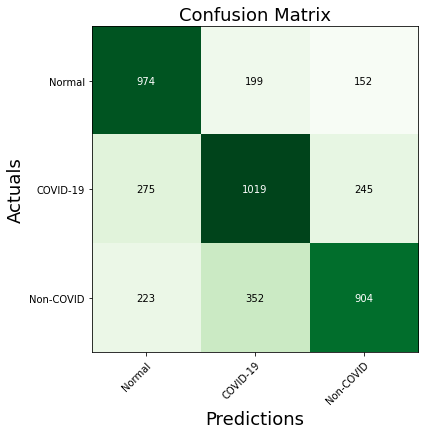

In [40]:
with open(plib.train_data_file, 'rb') as f:
    train_X = np.load(f, allow_pickle=True)
    train_Y = np.load(f, allow_pickle=True)

with open(plib.test_data_file, 'rb') as f:
    test_X = np.load(f, allow_pickle=True)
    test_Y = np.load(f, allow_pickle=True)

model = HistGradientBoostingClassifier(max_bins=255, max_iter=100)

model.fit(train_X, train_Y)

train_pred_y = model.predict(train_X)
test_pred_y = model.predict(test_X)

print("==================== Training Report")
print(classification_report(train_Y, train_pred_y, target_names=list(plib.classes.keys())))
print("==================== Test Report")
print(classification_report(test_Y, test_pred_y, target_names=list(plib.classes.keys())))

cm_hgb = confusion_matrix(test_Y, test_pred_y)

fig, ax = plot_confusion_matrix(conf_mat=cm_hgb, figsize=(6, 6), cmap=plt.cm.Greens, class_names=list(plib.classes.keys()))
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

### Hyperparameter Tuning

In [25]:
from sklearn.model_selection import GridSearchCV

In [34]:
%%time

hparam_grid = [{'max_iter': [100, 250, 500,1000],
                'learning_rate': [0.001, 0.01, 0.1],
                'max_depth' : [25, 50, 75, 100],
                'l2_regularization': [0.0001, 0.001, 0.01, 0.1]}]

grid_search_hgb = GridSearchCV(estimator = HistGradientBoostingClassifier(),
                           param_grid = hparam_grid,
                           scoring = 'accuracy',
                           cv = 10,
                           n_jobs = -1)

grid_search_hgb.fit(train_X, train_Y)
best_accuracy_hgb = grid_search_hgb.best_score_
best_paramaeter_hgb = grid_search_hgb.best_params_

print("Best Accuracy of HGB: {:.2f} %".format(best_accuracy_hgb.mean()*100))
print("Best Parameter of HGB:", best_paramaeter_hgb)                            

Best Accuracy of HGB: 66.79 %
Best Parameter of HGB: {'l2_regularization': 0.1, 'learning_rate': 0.1, 'max_depth': 25, 'max_iter': 250, 'scoring': 'f1_micro'}
CPU times: user 7min 31s, sys: 20.3 s, total: 7min 51s
Wall time: 55min 2s


In [36]:
%%time

hparam_grid = [{'max_leaf_nodes': [10, 25, 50, 100],
                'min_samples_leaf': [10, 20, 50, 100],
                'max_bins' : [20, 50, 100, 255]}]

grid_search_hgb = GridSearchCV(estimator = HistGradientBoostingClassifier(max_iter=250, learning_rate=0.1, max_depth=25, l2_regularization=0.1),
                           param_grid = hparam_grid,
                           scoring = 'accuracy',
                           cv = 10,
                           n_jobs = -1)

grid_search_hgb.fit(train_X, train_Y)
best_accuracy_hgb = grid_search_hgb.best_score_
best_paramaeter_hgb = grid_search_hgb.best_params_

print("Best Accuracy of HGB: {:.2f} %".format(best_accuracy_hgb.mean()*100))
print("Best Parameter of HGB:", best_paramaeter_hgb)                            

Best Accuracy of HGB: 67.04 %
Best Parameter of HGB: {'max_bins': 255, 'max_leaf_nodes': 100, 'min_samples_leaf': 100}
CPU times: user 2min 34s, sys: 6.58 s, total: 2min 40s
Wall time: 20min 26s


### Final Classifier configuration after Hyperparameter tuning

==================== Training Report
              precision    recall  f1-score   support

      Normal       0.97      0.98      0.97      5165
    COVID-19       0.96      0.97      0.96      5721
   Non-COVID       0.97      0.96      0.97      5400

    accuracy                           0.97     16286
   macro avg       0.97      0.97      0.97     16286
weighted avg       0.97      0.97      0.97     16286

==================== Test Report
              precision    recall  f1-score   support

      Normal       0.66      0.74      0.70      1325
    COVID-19       0.65      0.66      0.66      1539
   Non-COVID       0.69      0.61      0.65      1479

    accuracy                           0.67      4343
   macro avg       0.67      0.67      0.67      4343
weighted avg       0.67      0.67      0.67      4343



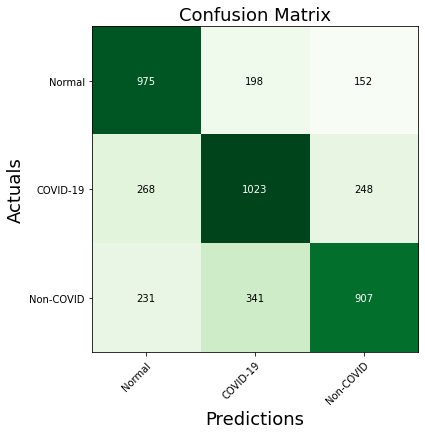

In [38]:
with open(plib.train_data_file, 'rb') as f:
    train_X = np.load(f, allow_pickle=True)
    train_Y = np.load(f, allow_pickle=True)

with open(plib.test_data_file, 'rb') as f:
    test_X = np.load(f, allow_pickle=True)
    test_Y = np.load(f, allow_pickle=True)

model = HistGradientBoostingClassifier(max_iter=250, learning_rate=0.1, max_depth=25, l2_regularization=0.1, max_bins=255, max_leaf_nodes=100, min_samples_leaf=100)

model.fit(train_X, train_Y)

train_pred_y = model.predict(train_X)
test_pred_y = model.predict(test_X)

print("==================== Training Report")
print(classification_report(train_Y, train_pred_y, target_names=list(plib.classes.keys())))
print("==================== Test Report")
print(classification_report(test_Y, test_pred_y, target_names=list(plib.classes.keys())))

cm_hgb = confusion_matrix(test_Y, test_pred_y)

fig, ax = plot_confusion_matrix(conf_mat=cm_hgb, figsize=(6, 6), cmap=plt.cm.Greens, class_names=list(plib.classes.keys()))
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()